In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.regions import connected_label_regions
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img, smooth_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.stats.mstats import pearsonr
from scipy.stats import zscore
import scipy.stats as stats

# Homemade functions

In [2]:
def Merge(dict1, dict2):

    # create a new dictionary by merging the items of the two dictionaries using the union operator (|)
    merged_dict = dict(dict1.items() | dict2.items())
    
    # return the merged dictionary
    return merged_dict

def merge_dictionaries(dict1, dict2):
    merged_dict = dict1.copy()
    merged_dict.update(dict2)
    return merged_dict

In [3]:
def plot_trailer_correlations(ROI_df, Trailer_id, ROI_id, TR_corr_dict, type_of_corr, axs):

    if(type_of_corr == "W_score"):
        color="green"
        bonus_y = 0.00
        score_label = "_w"
        text_label = "W corr"
    elif(type_of_corr == "Pos_arousal"):
        color="blue"
        bonus_y = 0.05
        score_label = "_pa"
        text_label = "PA corr"
    elif(type_of_corr == "Neg_arousal"):
        color="red"
        bonus_y = -0.05
        score_label = "_na"
        text_label = "NA corr"

    if(ROI_id == "Bilateral_NAcc"):
        y_coord_seg = 0.3 + bonus_y
        y_coord_whole = 0.4
    elif(ROI_id == "Bilateral_AIns"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5
    elif(ROI_id == "Bilateral_MPFC"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5

    # Get the dataframe for the current trailer.
    current_traile_df = ROI_df[Trailer_id]

    # Loop for plotting each significant correlation across the 15 TRs.
    for TR_id in range(15):
        TR_label = str("TR_" + str(TR_id) + score_label) 
        y_coord = current_traile_df[(current_traile_df["ROI"] == ROI_id) & (current_traile_df["TR"] == TR_id)]["Signal"].mean() + bonus_y
        x_coord = TR_id
        if(TR_corr_dict[Trailer_id][TR_label][1] < 0.05):
            if(TR_corr_dict[Trailer_id][TR_label][0] > 0):
                axs.text(x_coord, y_coord, "+*", fontsize=13, color=color, weight="bold", label=text_label)
            else:
                axs.text(x_coord, y_coord, "-*", fontsize=13, color=color, weight="bold", label=text_label)
    
    # Plot the onset correlation if significant.
    #current_traile_df = ROI_df[Trailer_id]
    Onset_label = str("Onset" + score_label)
    #y_coord_seg = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].mean() ) + bonus_y #* 0.7
    x_coord_onset = 3

    if(TR_corr_dict[Trailer_id][Onset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Onset_label][0] > 0):
            axs.text(x_coord_onset, y_coord_seg, "on(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_onset, y_coord_seg, "on(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the middle correlation if significant.
    Middle_label = str("Middle" + score_label)
    x_coord_middle = 7
    if(TR_corr_dict[Trailer_id][Middle_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Middle_label][0] > 0):
            axs.text(x_coord_middle, y_coord_seg, "mid(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_middle, y_coord_seg, "mid(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the offset correlation if significant.
    Offset_label = str("Offset" + score_label)
    x_coord_offset = 13
    if(TR_corr_dict[Trailer_id][Offset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Offset_label][0] > 0):
            axs.text(x_coord_offset, y_coord_seg, "off(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_offset, y_coord_seg, "off(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the whole correlation if significant.
    Whole_label = str("Whole" + score_label)
    x_coord_whole = 7
    #y_coord_whole = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].max() ) + bonus_y # * 0.8
    if(TR_corr_dict[Trailer_id][Whole_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Whole_label][0] > 0):
            axs.text(x_coord_whole, y_coord_whole, "whole(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_whole, y_coord_whole, "whole(-)", fontsize=13, color=color, weight="bold", label=text_label)
    



In [4]:
# Define a function to invert scores if needed. 
def transform_scores(score, invert):
    if(invert==1): #if(not invert):
        if(score == 1):  
            return 4
        elif(score == 2):  
            return 3
        elif(score == 3):  
            return 2
        elif(score == 4):  
            return 1
        elif(score == "1"):  
            return 4
        elif(score == "2"):  
            return 3
        elif(score == "3"):  
            return 2
        elif(score == "4"):  
            return 1
        elif(score == "None"):
            return 0
        else: 
            return "Something went wrong here!"
    else:
        if(score == "1"):
            return 1
        elif(score == "2"):
            return 2
        elif(score == "3"):
            return 3
        elif(score == "4"):
            return 4
        elif(score == 1):
            return 1
        elif(score == 2):
            return 2
        elif(score == 3):
            return 3
        elif(score == 4):
            return 4
        elif(score == "None"):
            return 0
        else:
            return "Something went wrong here!"

In [6]:
def process_events_data(run_dataframe):

    proccesed_events_df = pd.DataFrame(columns={"Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"}) 

    # Initial fixation 12 sec (TR=6).
    in_fix = 12

    # Time it take subjects to complete questionnaire 12 sec (TR=6). 
    questionnaire_duration = 12

    # All trailers last 30 sec (TR=15). 
    trailer_duration = 30

    # Initialize this variable, though it will change through each iteration of the loop.
    trailer_onset = 0

    # Run a for loop for each row in the df. 
    for id in range(run_dataframe.shape[0]):

        # Get trailer label and separate them accroding to their type. 
        trailer_name = run_dataframe["label"][id]
        trailer_type = "Horror" if "h" in run_dataframe["label"][id] else "Comedy"

        # This onsets don't work, so I need to re-calculate them
        traile_iti = run_dataframe["trial_ITI"][id]
        
        # For the first run add the initial fixation time to the calculation of the first trailer onset. 
        # After the first run, calculate onset by adding previous traile onset, questionnaire duration, and trial iti.
        if (id == 0):
            trailer_onset += in_fix
        else:
            trailer_onset += trailer_duration + questionnaire_duration + traile_iti

        # Calculate trailer onset. 
        trailer_offset = trailer_onset + 30 

        """ 
        For the questionnaire scores, as I understood it. If they were not inverted (["scale_flip"] == 0), then 
        the lower the score the stronger the response. If they were inverted (["scale_flip"] == 1), the higher the 
        score the stronger the response.
        """
        # Check if scaled was flipped and put scores on the same scale. 
        # For me, the most intuitive is that the higher the score, the stronger the response. 
        trailer_watch_score = transform_scores(run_dataframe["exp_Watch.keys"][id], run_dataframe["scale_flip"][id])
        trailer_arousal_score = transform_scores(run_dataframe["exp_Arousal.keys"][id], run_dataframe["scale_flip"][id])
        trailer_feel_score = transform_scores(run_dataframe["exp_Feel.keys"][id], run_dataframe["scale_flip"][id])

        # Place processed data on list, add list to new dataframe, and concat to main dataframe. 
        current_row_data = [[trailer_name, trailer_type, trailer_onset, trailer_duration, trailer_offset, trailer_watch_score, trailer_arousal_score, trailer_feel_score]]
        current_row = pd.DataFrame(data=current_row_data, columns=["Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"]) 
        proccesed_events_df = pd.concat([proccesed_events_df, current_row], ignore_index=True)
        proccesed_events_df = proccesed_events_df[["Trailer", "Type", "Onset", "Offset", "Duration", "W_score", "A_score", "F_score"]]

    # Add a column for the mean centered arousal and valence scores.
    mean_centered_arousal = proccesed_events_df["A_score"]/proccesed_events_df["A_score"].mean()
    mean_centered_valence = proccesed_events_df["F_score"]/proccesed_events_df["F_score"].mean()

    # Derive the positive and negative arousal scores.
    proccesed_events_df["Pos_arousal"] = (mean_centered_arousal+mean_centered_valence)/np.sqrt(2)
    proccesed_events_df["Neg_arousal"] = (mean_centered_arousal-mean_centered_valence)/np.sqrt(2)

    # Derive the positive and negative arousal scaled scores. 
    pos_arousal_mean = proccesed_events_df["Pos_arousal"].mean()
    neg_arousal_mean = proccesed_events_df["Neg_arousal"].mean()

    proccesed_events_df["Pos_arousal_scaled"] = (proccesed_events_df["Pos_arousal"] - pos_arousal_mean)
    proccesed_events_df["Neg_arousal_scaled"] = (proccesed_events_df["Neg_arousal"] - neg_arousal_mean)

    # Derive scales Watch scores. 
    watch_score_mean = proccesed_events_df["W_score"].mean()    
    proccesed_events_df["W_score_scaled"] = (proccesed_events_df["W_score"] - watch_score_mean)

    return proccesed_events_df

In [7]:
def access_trailer(dictionary, trailer_key): 
    try:
        trailer_data = dictionary[trailer_key]
        return trailer_data
    except KeyError:
        pass    

def access_timecourse(dictionary, roi_key):
    
    dictionary_keys = list(dictionary.keys())

    if((roi_key in dictionary_keys) and (dictionary[roi_key] is not None) and (dictionary[roi_key] is not "None")):
        roi_data = np.array(dictionary[roi_key])
        return roi_data
    
    
    # try:
    #     print(dictionary)
    #     if(dictionary[roi_key] == None):
    #         print("This is empty!")
    #         print(dictionary[roi_key])
    #     if(dictionary[roi_key] is not None):
    #         roi_data = np.array(dictionary[roi_key])
    #         return roi_data
    
    # except KeyError:
    #     pass


def trim_timecourse_per_roi(timecourses_dictionary_list, timecourses_dictionary_raw, ROI):

    # 1) Create a new dictionary to store the trimmed timecourses.
    # First file will store the avg timecourse for each trailer per roi (ROI x trailer).
    # Second file will store the timecourse of all subjects for each trailer per roi (ROI x subjects x trailer).
    # Third file will store the timecourse of all subjects for each trailer per roi in a dataframe (ROI x subjects x trailer).
    all_subjects_avg_ROI_timecourse = {}
    all_subjects_ROI_timecourse = {}
    all_subjects_ROI_timecourse_df = {}

    bROI = "Bilateral_" + ROI
    bROI_r1 = "Bilateral_" + ROI + "_r1"
    bROI_r2 = "Bilateral_" + ROI + "_r2"
    rROI = "Right_" + ROI
    rROI_r1 = "Right_" + ROI + "_r1"
    rROI_r2 = "Right_" + ROI + "_r2"
    lROI = "Left_" + ROI
    lROI_r1 = "Left_" + ROI + "_r1"
    lROI_r2 = "Left_" + ROI + "_r2"

    # Get all keys from the first participant dictionary.
    trailer_list = list(timecourses_dictionary_list["sub-01"].keys())
    subjects_list = list(timecourses_dictionary_raw.keys())

    if(ROI != "V1"):
        # Loop through all trailer keys.
        for id in range(len(trailer_list)): 
    
            # Create new participant list with only participants that have the current trailer.
            participants_with_trailer = [d for d in timecourses_dictionary_list if trailer_list[id] in timecourses_dictionary_list[d]] # Store participant id if they have the current trailer.
        
            # Make copy of dictionary with only participants that have the current trailer.
            timecourses_dictionary_list_current_trailer = {k: timecourses_dictionary_list[k] for k in participants_with_trailer}
        
            # Loop through all participants and get the values for the current trailer.
            # Note, a wrapper function just to return the values for the current trailer.
            # if they exist, otherwise return None.
            values = [access_trailer(timecourses_dictionary_list_current_trailer[d], trailer_list[id]) for d in timecourses_dictionary_list_current_trailer] 
        
            values_Bilateral_ROI = [values[d][bROI] for d in range(len(values))]
            values_Right_ROI = [values[d][rROI] for d in range(len(values))]
            values_Left_ROI = [values[d][lROI] for d in range(len(values))]

            # Compute the average for each roi.
            averageBilateral_ROI = np.mean(values_Bilateral_ROI, axis=0)
            averageRight_ROI = np.mean(values_Right_ROI, axis=0)
            averageLeft_ROI = np.mean(values_Left_ROI, axis=0)

            # Row are timepoints, columns are participants (15 x P).
            values_Bilateral_ROI_array = np.array(values_Bilateral_ROI).T 
            values_Right_ROI_array = np.array(values_Right_ROI).T
            values_Left_ROI_array = np.array(values_Left_ROI).T

            # Create columns names for the dataframe.
            TRs = np.arange(0, 15, 1)

            # Creat empty dataframe for current trailer. 
            trailer_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])   

            current_participant_dic = {}

            for current_participant in range(len(participants_with_trailer)):

                # Create dictionary with all the timecourses for all trailers for each subject.
                current_participant_dic[participants_with_trailer[current_participant]] = {bROI: values_Bilateral_ROI_array[:, current_participant],
                                                                                       lROI: values_Left_ROI_array[:, current_participant], 
                                                                                       rROI: values_Right_ROI_array[:, current_participant]}
 
                participant_col = np.repeat(str(participants_with_trailer[current_participant]), 15)
                label_bi = np.repeat(bROI, 15)
                label_left = np.repeat(lROI, 15)
                label_right = np.repeat(rROI, 15)
                roi_labels = [label_bi, label_left, label_right]

                # Store current participant values. 
                current_participant_bi = values_Bilateral_ROI_array[:, current_participant]
                current_participant_left = values_Left_ROI_array[:, current_participant]
                current_participant_right = values_Right_ROI_array[:, current_participant]
                current_participant_values = [current_participant_bi, current_participant_left, current_participant_right]

                for x in range(3):

                    current_participant_roi_data = {
                        "Participant": participant_col,
                        "ROI": roi_labels[x],
                        "Signal": current_participant_values[x],
                        "TR": TRs
                    }
            
                    participant_df = pd.DataFrame(data=current_participant_roi_data)

                    trailer_df = pd.concat([trailer_df, participant_df], ignore_index=True)
        
            # store the all in the results dictionaries.
            all_subjects_avg_ROI_timecourse[trailer_list[id]] = {bROI: averageBilateral_ROI, lROI: averageLeft_ROI, rROI: averageRight_ROI}
            all_subjects_ROI_timecourse[trailer_list[id]] = current_participant_dic
            all_subjects_ROI_timecourse_df[trailer_list[id]] = trailer_df
    
    # Get average timecourse for all subjects in the current ROI. 
    Bilateral_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r1) for sub_id in subjects_list] # if timecourses_dictionary_raw[sub_id][bROI_r1] is not None
    Bilateral_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r2) for sub_id in subjects_list]
    Right_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], rROI_r1) for sub_id in subjects_list]
    Right_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], rROI_r2) for sub_id in subjects_list]
    Left_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], lROI_r1) for sub_id in subjects_list]
    Left_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], lROI_r2) for sub_id in subjects_list]    

    # Remove None values from the list.
    Bilateral_ROI_raw_r1_list = [x for x in Bilateral_ROI_raw_r1_list if x is not None]
    Bilateral_ROI_raw_r2_list = [x for x in Bilateral_ROI_raw_r2_list if x is not None]
    Right_ROI_raw_r1_list = [x for x in Right_ROI_raw_r1_list if x is not None]
    Right_ROI_raw_r2_list = [x for x in Right_ROI_raw_r2_list if x is not None]
    Left_ROI_raw_r1_list = [x for x in Left_ROI_raw_r1_list if x is not None]
    Left_ROI_raw_r2_list = [x for x in Left_ROI_raw_r2_list if x is not None]

    # Get the average timecourse for all subjects in the current ROI.
    Bilateral_ROI_raw_r1_average = np.mean(Bilateral_ROI_raw_r1_list, axis=0)
    Bilateral_ROI_raw_r2_average = np.mean(Bilateral_ROI_raw_r2_list, axis=0)
    Right_ROI_raw_r1_average = np.mean(Right_ROI_raw_r1_list, axis=0)
    Right_ROI_raw_r2_average = np.mean(Right_ROI_raw_r2_list, axis=0)
    Left_ROI_raw_r1_average = np.mean(Left_ROI_raw_r1_list, axis=0)
    Left_ROI_raw_r2_average = np.mean(Left_ROI_raw_r2_list, axis=0)

    # Create TR array.
    TRs_raw = np.arange(0, 378, 1)

    # Put everything in a list 
    ROI_raw_list = [Bilateral_ROI_raw_r1_average, Bilateral_ROI_raw_r2_average, Right_ROI_raw_r1_average, Right_ROI_raw_r2_average, Left_ROI_raw_r1_average, Left_ROI_raw_r2_average]
    ROI_raw_labels = [bROI_r1, bROI_r2, rROI_r1, rROI_r2, lROI_r1, lROI_r2]

    # Creat empty dataframe. 
    all_subjects_avg_ROI_timecourse_raw_df = pd.DataFrame(columns=["ROI", "Signal", "TR"])  

    for ROI_id in range(6):

        current_roi_data = {        
            "ROI": ROI_raw_labels[ROI_id],
            "Signal": ROI_raw_list[ROI_id],
            "TR": TRs_raw}
            
        current_roi_df = pd.DataFrame(data=current_roi_data)

        all_subjects_avg_ROI_timecourse_raw_df = pd.concat([all_subjects_avg_ROI_timecourse_raw_df, current_roi_df], ignore_index=True)


    return all_subjects_avg_ROI_timecourse, all_subjects_ROI_timecourse, all_subjects_ROI_timecourse_df, all_subjects_avg_ROI_timecourse_raw_df


<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25911/1498170635.py:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if((roi_key in dictionary_keys) and (dictionary[roi_key] is not None) and (dictionary[roi_key] is not "None")):


In [8]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [9]:
# Create narrow_z.
# I was using the whole time-series to z-score and find outliers (< 3 std). However, there might be too noise in the whole time-series.
# Hence, making it difficult to find the outliers in the time where trailers are presented. For this reason, I will create a new z-scored
# time-series using only the time where trailers are presented.

# Create function to get the z-scored time-series for each ROI in the first run.
def get_narrow_z_timeseries_r1(sub_dict):

    # Create list with the trailers from run 1.
    r1_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6',
                'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']
    
    # Create a list to store the timecourses for each ROI.
    NAcc_data_list = []
    AIns_data_list = []
    MPFC_data_list = []
    
    # Loop through each trailer and get the timecourse for each ROI.
    for id_trailer in range(len(r1_keys)):
            
            # Append the timecourse for each ROI to the list.
            NAcc_data_list.append(sub_dict[r1_keys[id_trailer]]["Bilateral_NAcc"])
            AIns_data_list.append(sub_dict[r1_keys[id_trailer]]["Bilateral_AIns"])
            MPFC_data_list.append(sub_dict[r1_keys[id_trailer]]["Bilateral_MPFC"])

    # Convert lists to arrays.
    NAcc_data = np.array(NAcc_data_list).flatten()
    AIns_data = np.array(AIns_data_list).flatten()
    MPFC_data = np.array(MPFC_data_list).flatten()

    # Z-score the timecourses.
    NAcc_z = zscore(NAcc_data)
    AIns_z = zscore(AIns_data)
    MPFC_z = zscore(MPFC_data)

    # Transform back into dictionary.
    Sub_z_dict = {}

    # Create a runner variable to loop through the z-scored timecourses.
    runner = 0

    # Loop through each trailer and get the z-scored timecourse for each ROI.
    for id_trailer in range(len(r1_keys)):

        # Create a dictionary to store the z-scored timecourse for each ROI.
        current_trailer_dict = {} 

        # Append the z-scored timecourse for each ROI to the dictionary. 
        current_trailer_dict["Bilateral_NAcc"] = NAcc_z[runner:runner+15]
        current_trailer_dict["Bilateral_AIns"] = AIns_z[runner:runner+15]
        current_trailer_dict["Bilateral_MPFC"] = MPFC_z[runner:runner+15]

        # Append the z-scored timecourse for each ROI to the dictionary.
        Sub_z_dict[r1_keys[id_trailer]] = current_trailer_dict

        # Update the runner variable.
        runner += 15

    return Sub_z_dict

# Create function to get the z-scored time-series for each ROI in the second run.
def get_narrow_z_timeseries_r2(sub_dict):

    # Create list with the trailers from run 2.
    r2_keys = ['rh12', 'rc3', 'rh7', 'rc1', 'rh10', 'rc8', 'rh4', 'uc3', 'rh5', 'rc4', 'rh8', 'uc2', 'uh3', 'rc10', 'uh4', 'rc7']
    
    # Create a list to store the timecourses for each ROI.
    NAcc_data_list = []
    AIns_data_list = []
    MPFC_data_list = []
    
    # Loop through each trailer and get the timecourse for each ROI.
    for id_trailer in range(len(r2_keys)):
            
            # Append the timecourse for each ROI to the list.
            NAcc_data_list.append(sub_dict[r2_keys[id_trailer]]["Bilateral_NAcc"])
            AIns_data_list.append(sub_dict[r2_keys[id_trailer]]["Bilateral_AIns"])
            MPFC_data_list.append(sub_dict[r2_keys[id_trailer]]["Bilateral_MPFC"])

    # Convert lists to arrays.
    NAcc_data = np.array(NAcc_data_list).flatten()
    AIns_data = np.array(AIns_data_list).flatten()
    MPFC_data = np.array(MPFC_data_list).flatten()

    # Z-score the timecourses.
    NAcc_z = zscore(NAcc_data)
    AIns_z = zscore(AIns_data)
    MPFC_z = zscore(MPFC_data)

    # Transform back into dictionary.
    Sub_z_dict = {}

    # Create a runner variable to loop through the z-scored timecourses.
    runner = 0

    # Loop through each trailer and get the z-scored timecourse for each ROI.
    for id_trailer in range(len(r2_keys)):

        # Create a dictionary to store the z-scored timecourse for each ROI.
        current_trailer_dict = {} 

        # Append the z-scored timecourse for each ROI to the dictionary. 
        current_trailer_dict["Bilateral_NAcc"] = NAcc_z[runner:runner+15]
        current_trailer_dict["Bilateral_AIns"] = AIns_z[runner:runner+15]
        current_trailer_dict["Bilateral_MPFC"] = MPFC_z[runner:runner+15]

        # Append the z-scored timecourse for
        Sub_z_dict[r2_keys[id_trailer]] = current_trailer_dict

        # Update the runner variable.
        runner += 15

    return Sub_z_dict


In [9]:

def getROIs_timecourse(participant_num, sub_motion): 

    # Add code to flag if something that is not a number is passed. 

    ## 1) Load data.
    # Load relevant files for participant
    sub_run1_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_run2_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

    sub_run1_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    sub_run2_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

    sub_run1_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_events.csv"
    sub_run2_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_events.csv"

    sub_run1_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.tsv"
    sub_run2_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_desc-confounds_timeseries.tsv"

    # Calculate relevant parameters for GLM and ROI time-course analysis.
    func_file = nib.load(sub_run1_func_path)
    func_data = func_file.get_fdata()
    n_vols = func_data.shape[3]
    TR = 2
    n_timepoints = n_vols*TR

    # Load raw events files. 
    sub_run1_events_df = pd.read_csv(sub_run1_events_path, index_col=0)
    sub_run2_events_df = pd.read_csv(sub_run2_events_path, index_col=0)

    ## 2) Process files. 
    # Process event files. 
    sub_run1_p_events = process_events_data(sub_run1_events_df)
    sub_run2_p_events = process_events_data(sub_run2_events_df)

    # Down-sample time onsets to get vol onsets. 
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, n_timepoints, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, n_timepoints, TR)  

    # Get the labels of each trailer for each run. 
    run1_trailer_labels = sub_run1_p_events["Trailer"].tolist()
    run2_trailer_labels = sub_run2_p_events["Trailer"].tolist()

    # Create dictionary variable to store arrays with onset values for each trailer. 
    run1_onsets = {}
    run2_onsets = {}

    # Create a dictionary with all the onsets for each trailer in each run. 
    for id in range(len(run1_trailer_labels)):

        # Create array of zeros.
        run1_trailer_onsets = np.zeros(n_timepoints)
        run2_trailer_onsets = np.zeros(n_timepoints)

        # Get onset time. 
        run1_current_trailer_onset = sub_run1_p_events["Onset"][id]
        run2_current_trailer_onset = sub_run2_p_events["Onset"][id]

        # Assign 1 to such onset all the way til the end of the trailer (30 sec) in the array of zeros.
        # Adjust for lag: add 4 seconds at the onset and offset
        # Let's add 4 seconds to the onset and offset to account for the lag in the BOLD signal.
        run1_trailer_onsets[int(run1_current_trailer_onset + 4):int(run1_current_trailer_onset)+ 30 + 4] = 1
        run2_trailer_onsets[int(run2_current_trailer_onset + 4):int(run2_current_trailer_onset)+ 30 + 4] = 1
        #run1_trailer_onsets[int(run1_current_trailer_onset + 5):int(run1_current_trailer_onset)+ 30 + 5] = 1
        #run2_trailer_onsets[int(run2_current_trailer_onset + 5):int(run2_current_trailer_onset)+ 30 + 5] = 1

        # Create resampler objects for each trailer/run of reward.
        run1_resampler = interp1d(time_scale, run1_trailer_onsets)
        run2_resampler = interp1d(time_scale, run2_trailer_onsets)

        # Create downsampled arrays for each trailer. 
        # Note this vol arrays are half the length than the time arrays.
        run1_trailer_vol_onsets = run1_resampler(vol_scale)
        run2_trailer_vol_onsets = run2_resampler(vol_scale)

        # Append/store the downsampled volumes arrays to each dictionary.
        # I'm doing it this way, so the code is more interpretable
        run1_onsets[run1_trailer_labels[id]] = run1_trailer_vol_onsets
        run2_onsets[run2_trailer_labels[id]] = run2_trailer_vol_onsets

    ## 3) Load confound data. 
    sub_run1_confounds_df = pd.read_csv(sub_run1_confounds_path, sep='\t')
    sub_run2_confounds_df = pd.read_csv(sub_run2_confounds_path, sep='\t')
    default_confounds = ["white_matter", "csf", "csf_wm", "framewise_displacement", "dvars", "rmsd", "tcompcor"] 
    # ["white_matter", "csf", "csf_wm", "framewise_displacement",  "rmsd", "tcompcor"]
    
    cohen_confounds = ['c_comp_cor_00','c_comp_cor_01','c_comp_cor_02','w_comp_cor_00','w_comp_cor_01','w_comp_cor_02',
                       'w_comp_cor_03','w_comp_cor_04','trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','trans_x_derivative1'
                       ,'trans_y_derivative1','trans_z_derivative1','rot_x_derivative1','rot_y_derivative1','rot_z_derivative1',
                       'trans_x_power2','trans_y_power2','trans_z_power2','rot_x_power2','rot_y_power2','rot_z_power2',
                       'trans_x_derivative1_power2','trans_y_derivative1_power2','trans_z_derivative1_power2','rot_x_derivative1_power2',
                       'rot_y_derivative1_power2','rot_z_derivative1_power2','cosine00'] #, 'c_comp_cor_03', 'c_comp_cor_04'

    """
    Check if ISC scores improve with motion event covariates
    """
    sub_run1_motion_s_confounds = [i for i in sub_run1_confounds_df.columns if "state" in i] #"motion"
    sub_run2_motion_s_confounds = [i for i in sub_run2_confounds_df.columns if "state" in i] 

    sub_run1_motion_confounds = [i for i in sub_run1_confounds_df.columns if "motion" in i] #"motion"
    sub_run2_motion_confounds = [i for i in sub_run2_confounds_df.columns if "motion" in i] 

    sub_run1_cohen_confounds_df = sub_run1_confounds_df[cohen_confounds ] #+ sub_run1_motion_s_confounds
    sub_run2_cohen_confounds_df = sub_run2_confounds_df[cohen_confounds ] #+ sub_run2_motion_s_confounds

    # Change NaNs to 0s. 
    sub_run1_cohen_confounds_df = sub_run1_cohen_confounds_df.fillna(0) 
    sub_run2_cohen_confounds_df = sub_run2_cohen_confounds_df.fillna(0) 

    # Specify the parameters to apply to the given analysis.

    detrend = False #True # False
    standardize = "zscore"
    standardize_confounds = "zscore" #False #type
    sphere_radius = 8 # from 6 to 8
    confounds1 = sub_run1_cohen_confounds_df
    confounds2 = sub_run2_cohen_confounds_df
    smoothing= 4 # from 6 to 4
    Pauli_path = "/Users/luisalvarez/Documents/Datasets/CIT168_Reinf_Learn_v1.1.0/prob_atlas_bilateral.nii.gz"
    
    ## 4) Apply mask to func data. 
    masker_Pauli_ROI_r1 =  NiftiMapsMasker(
        maps_img=Pauli_path,
        allow_overlap=True,
        smoothing_fwhm=smoothing, # Applying a Gaussian filter with a 4mm kernel
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run1_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_pass=1/360, # High cutoff frequency in Hertz. # Try 0.011
        #low_pass=0.1 # from 1.0
        )

    masker_Pauli_ROI_r2 = NiftiMapsMasker(
        maps_img=Pauli_path,
        allow_overlap=True,
        smoothing_fwhm=smoothing, # Applying a Gaussian filter with a 4mm kernel
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run2_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_pass=1/360, # High cutoff frequency in Hertz. # Try 0.011
        #low_pass=0.1 # from 1.0
        )

    ROI_raw_timecourses = {}
    # Mask the func data and get a time series for the ROI. 
    # Note this is similar to fitting the GLM, but without the event files.
    ## Add if statement to only apply the masker if the run has acceptable motion parameters. 

    if((sub_motion[0] < 1) and (sub_motion[1] < 1)):

        # Apply function to get the percent signal change from each ROI timecourse. 
        sub_r1_ROI = masker_Pauli_ROI_r1.fit_transform(sub_run1_func_path, confounds=confounds1)

        ## 5) Get the timecourses from each movie trailer. 
        # Create dictionary variable to store arrays with time series arrays for each trailer.
        run1_timeseries = {}

        # Get the trailers presented in each run. 
        r1_keys = list(run1_onsets.keys())

        # Loop through each trailer and get its corresponding ROI timecourse
        for id in range(len(r1_keys)):

            run1_timeseries[r1_keys[id]] = {
                
                "Putamen": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
                "Caudate": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
                "Nacc": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2],
                "Ext_Amygdala": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 3],
                "GB_externa": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 4],
                "GB_interna": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 5],
                "SN_compacta": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 6],
                "Red_nucleus": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 7],
                "SN_reticulata": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 8],
                "PBP": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 9],
                "VTA": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 10],
                "VeP": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 11],
                "Habenular_Nuclei": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 12],
                "Hypothalamus": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 13],
                "Mammillary_Nucleus": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 14],
                "Subthalamic_Nucleus": sub_r1_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 15]}
        
        # This code gives me the un-trimmed timecourses for each ROI.
        ROI_raw_timecourses["Putamen_r1"] = sub_r1_ROI[:, 0]
        ROI_raw_timecourses["Caudate_r1"] = sub_r1_ROI[:, 1]
        ROI_raw_timecourses["Nacc_r1"] = sub_r1_ROI[:, 2]
        ROI_raw_timecourses["Ext_Amygdala_r1"] = sub_r1_ROI[:, 3]
        ROI_raw_timecourses["GB_externa_r1"] = sub_r1_ROI[:, 4]
        ROI_raw_timecourses["GB_interna_r1"] = sub_r1_ROI[:, 5]
        ROI_raw_timecourses["SN_compacta_r1"] = sub_r1_ROI[:, 6]
        ROI_raw_timecourses["Red_nucleus_r1"] = sub_r1_ROI[:, 7]
        ROI_raw_timecourses["SN_reticulata_r1"] = sub_r1_ROI[:, 8]
        ROI_raw_timecourses["PBP_r1"] = sub_r1_ROI[:, 9]
        ROI_raw_timecourses["VTA_r1"] = sub_r1_ROI[:, 10]
        ROI_raw_timecourses["VeP_r1"] = sub_r1_ROI[:, 11]
        ROI_raw_timecourses["Habenular_Nuclei_r1"] = sub_r1_ROI[:, 12]
        ROI_raw_timecourses["Hypothalamus_r1"] = sub_r1_ROI[:, 13]
        ROI_raw_timecourses["Mammillary_Nucleus_r1"] = sub_r1_ROI[:, 14]
        ROI_raw_timecourses["Subthalamic_Nucleus_r1"] = sub_r1_ROI[:, 15]

    # Apply for second run.
    if((sub_motion[2] < 1) and (sub_motion[3] < 1)):

        # Apply function to get the percent signal change from each ROI timecourse.
        sub_r2_AIM_ROI = masker_Pauli_ROI_r2.fit_transform(sub_run2_func_path, confounds=confounds2)

        # Create dictionary variable to store arrays with time series arrays for each trailer.
        run2_timeseries = {}

        r2_keys = list(run2_onsets.keys())

        # Loop through each traile and get its corresponding ROI timecourse
        for id in range(len(r2_keys)):
            run2_timeseries[r2_keys[id]] = {
                "Putamen": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
                "Caudate": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
                "Nacc": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2],
                "Ext_Amygdala": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 3],
                "GB_externa": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 4],
                "GB_interna": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 5],
                "SN_compacta": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 6],
                "Red_nucleus": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 7],
                "SN_reticulata": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 8],
                "PBP": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 9],
                "VTA": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 10],
                "VeP": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 11],
                "Habenular_Nuclei": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 12],
                "Hypothalamus": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 13],
                "Mammillary_Nucleus": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 14],
                "Subthalamic_Nucleus": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 15]}
        
        # This code gives me the un-trimmed timecourses for each ROI.
        ROI_raw_timecourses["Putamen_r2"] = sub_r2_AIM_ROI[:, 0]
        ROI_raw_timecourses["Caudate_r2"] = sub_r2_AIM_ROI[:, 1]
        ROI_raw_timecourses["Nacc_r2"] = sub_r2_AIM_ROI[:, 2]
        ROI_raw_timecourses["Ext_Amygdala_r2"] = sub_r2_AIM_ROI[:, 3]
        ROI_raw_timecourses["GB_externa_r2"] = sub_r2_AIM_ROI[:, 4]
        ROI_raw_timecourses["GB_interna_r2"] = sub_r2_AIM_ROI[:, 5]
        ROI_raw_timecourses["SN_compacta_r2"] = sub_r2_AIM_ROI[:, 6]
        ROI_raw_timecourses["Red_nucleus_r2"] = sub_r2_AIM_ROI[:, 7]
        ROI_raw_timecourses["SN_reticulata_r2"] = sub_r2_AIM_ROI[:, 8]
        ROI_raw_timecourses["PBP_r2"] = sub_r2_AIM_ROI[:, 9]
        ROI_raw_timecourses["VTA_r2"] = sub_r2_AIM_ROI[:, 10]
        ROI_raw_timecourses["VeP_r2"] = sub_r2_AIM_ROI[:, 11]
        ROI_raw_timecourses["Habenular_Nuclei_r2"] = sub_r2_AIM_ROI[:, 12]
        ROI_raw_timecourses["Hypothalamus_r2"] = sub_r2_AIM_ROI[:, 13]
        ROI_raw_timecourses["Mammillary_Nucleus_r2"] = sub_r2_AIM_ROI[:, 14]
        ROI_raw_timecourses["Subthalamic_Nucleus_r2"] = sub_r2_AIM_ROI[:, 15]

    ## 6) Merge timecourses and events data. 
    if((sub_motion[0] < 1) and (sub_motion[2] < 1)): 

        # Merge the timecourses for both runs.
        all_timeseries = merge_dictionaries(run1_timeseries, run2_timeseries)   
        sub_all_p_events = pd.concat([sub_run1_p_events, sub_run2_p_events], ignore_index=True)

    elif((sub_motion[0] < 1) and (sub_motion[2] > 1)): 
        
        # Only data for first run. 
        all_timeseries = run1_timeseries
        sub_all_p_events = sub_run1_p_events
    elif((sub_motion[0] > 1) and (sub_motion[2] < 1)):

        # Only data for second run.
        all_timeseries = run2_timeseries
        sub_all_p_events = sub_run2_p_events
    else:
        all_timeseries = {}
        sub_all_p_events = []


    # Create dictionary to store all the relevant output. 
    Output_dic = { 
        "ROI_trimmed_timeseries": all_timeseries, 
        "Processes_events": sub_all_p_events, 
        "ROI_raw_timeseries": ROI_raw_timecourses
    }
        
    return Output_dic



## Load and check Pauli et al. (2018) sub-cortical brain atlas.


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(


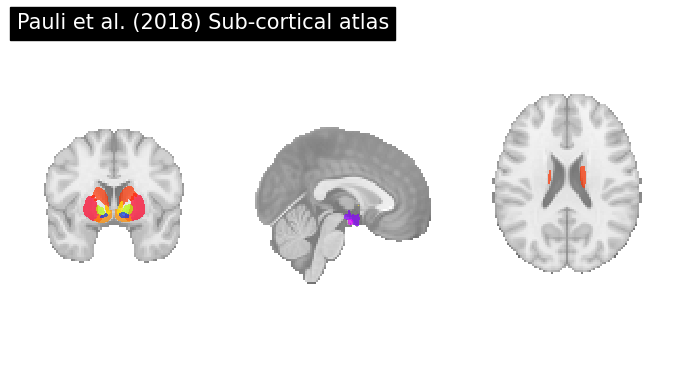

In [11]:
Pauli_path = "/Users/luisalvarez/Documents/Datasets/CIT168_Reinf_Learn_v1.1.0/prob_atlas_bilateral.nii.gz"
plot_prob_atlas(Pauli_path, cut_coords=None, title="Pauli et al. (2018) Sub-cortical atlas", annotate=False, draw_cross=False) #cut_coords=[15, 14, -5]

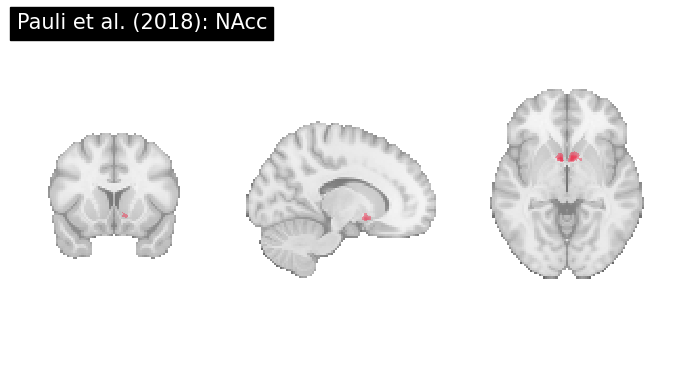

In [12]:
NAcc_map = index_img(Pauli_path, [2])

plot_prob_atlas(NAcc_map, cut_coords=[15, 14, -5], title="Pauli et al. (2018): NAcc", annotate=False, draw_cross=False) 

# Get inter-subject correlation (ISC). 

In [13]:
# Define each subject motion parameters from fMRIprep.
# The first value is the max framewise displacement, the second is the mean framewise displacement.
# Two values per run. 
sub01_motion = [0.911, 0.095, 0.571, 0.077]
sub02_motion = [0.663, 0.073, 0.734, 0.108]
sub03_motion = [0.456, 0.048, 0.300, 0.049]
sub04_motion = [0.607, 0.080, 0.519, 0.076]
sub05_motion = [1.612, 0.138, 1.403, 0.208]
sub06_motion = [3.008, 0.248, 4.225, 0.311]
sub07_motion = [8.275, 0.156, 0.531, 0.072]
sub08_motion = [0.597, 0.074, 0.482, 0.072]
sub09_motion = [0.367, 0.069, 0.475, 0.104]
sub10_motion = [0.597, 0.074, 0.679, 0.103]
sub11_motion = [0.540, 0.059, 0.394, 0.055]
sub12_motion = [0.649, 0.154, 0.529, 0.162]
sub13_motion = [0.468, 0.091, 0.459, 0.102]
sub14_motion = [2.538, 0.164, 1.245, 0.091]
sub15_motion = [0.844, 0.066, 1.163, 0.062]
sub16_motion = [0.688, 0.111, 3.026, 0.218]
sub17_motion = [0.626, 0.091, 0.376, 0.072]
sub18_motion = [0.777, 0.054, 0.699, 0.048]
sub19_motion = [1.593, 0.180, 0.789, 0.189]
sub20_motion = [1.476, 0.091, 5.681, 0.167]
sub21_motion = [0.935, 0.088, 0.856, 0.110]
sub22_motion = [0.729, 0.084, 1.021, 0.105]
sub23_motion = [0.582, 0.084, 0.496, 0.073] # head looks a bit weird
sub24_motion = [1.406, 0.109, 1.550, 0.088]
sub25_motion = [0.649, 0.092, 0.351, 0.059]
sub26_motion = [0.894, 0.105, 0.965, 0.127]
sub27_motion = [0.525, 0.081, 0.494, 0.070]
sub28_motion = [1.001, 0.103, 0.494, 0.094]
sub29_motion = [0.300, 0.052, 0.330, 0.052]
sub30_motion = [0.269, 0.063, 0.335, 0.068]
sub31_motion = [0.398, 0.066, 0.377, 0.075]
sub32_motion = [0.817, 0.113, 1.551, 0.153]
sub33_motion = [0.959, 0.120, 0.627, 0.107]
sub34_motion = [0.344, 0.058, 0.309, 0.051]
sub35_motion = [0.656, 0.064, 0.704, 0.071]
sub36_motion = [0.790, 0.107, 0.746, 0.105]
sub37_motion = [0.560, 0.071, 0.585, 0.086]

participants_motion_list = [sub01_motion, sub02_motion, sub03_motion, sub04_motion, sub05_motion, sub06_motion, sub07_motion, sub08_motion, sub09_motion, sub10_motion, sub11_motion, sub12_motion, sub13_motion, sub14_motion, sub15_motion, sub16_motion, sub17_motion, sub18_motion, sub19_motion, sub20_motion, sub21_motion, sub22_motion, sub23_motion, sub24_motion, sub25_motion, sub26_motion, sub27_motion, sub28_motion, sub29_motion, sub30_motion, sub31_motion, sub32_motion, sub33_motion, sub34_motion, sub35_motion, sub36_motion, sub37_motion]

In [16]:

# Record the number with good data for each run. 
run1_subs_list = []
run2_subs_list = []
particpants_list = []

# Create relevant dictionaries. 
all_subjects_timecourses_z_dic = {}
participant_dictionaries_raw = {}
participants_events = {}

for sub_id in range(len(participants_motion_list)):
    
    # Format participant number.
    current_sub = "sub-" + str(sub_id + 1).zfill(2)
    current_num = str(sub_id + 1).zfill(2)

    # Get the timecourses for each participant.
    current_sub_dic = getROIs_timecourse(current_num, participants_motion_list[sub_id])

    # Print message to indicate that the participant has been processed.
    current_sub_motion_r1 = participants_motion_list[sub_id][0]
    current_sub_motion_r2 = participants_motion_list[sub_id][2]

    # Append data to relevant dictionaries. 
    # Append the participant number to the list of participants.
    if((current_sub_motion_r1 < 1) and (current_sub_motion_r2 < 1)):
        all_subjects_timecourses_z_dic[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        run1_subs_list.append(current_sub)
        run2_subs_list.append(current_sub)
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for BOTH runs.")
    elif((current_sub_motion_r1 < 1) and (current_sub_motion_r2 > 1)):
        all_subjects_timecourses_z_dic[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        run1_subs_list.append(current_sub)
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for RUN_1 only.")
    elif((current_sub_motion_r1 > 1) and (current_sub_motion_r2 < 1)):
        all_subjects_timecourses_z_dic[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        run2_subs_list.append(current_sub)
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for RUN_2 only.")
    else:
        print("Participant " + current_sub + " has acceptable data for NONE of the runs.")

print("\nA total of " + str(len(run1_subs_list)) + " participants have acceptable data for RUN_1.")
print("A total of " + str(len(run2_subs_list)) + " participants have acceptable data for RUN_2.")
print("A total of " + str(len(particpants_list)) + " participants have usable data.")




Participant sub-01 has acceptable data for BOTH runs.
Participant sub-02 has acceptable data for BOTH runs.
Participant sub-03 has acceptable data for BOTH runs.
Participant sub-04 has acceptable data for BOTH runs.
Participant sub-05 has acceptable data for NONE of the runs.
Participant sub-06 has acceptable data for NONE of the runs.
Participant sub-07 has acceptable data for RUN_2 only.
Participant sub-08 has acceptable data for BOTH runs.
Participant sub-09 has acceptable data for BOTH runs.
Participant sub-10 has acceptable data for BOTH runs.
Participant sub-11 has acceptable data for BOTH runs.
Participant sub-12 has acceptable data for BOTH runs.
Participant sub-13 has acceptable data for BOTH runs.
Participant sub-14 has acceptable data for NONE of the runs.
Participant sub-15 has acceptable data for RUN_1 only.
Participant sub-16 has acceptable data for RUN_1 only.
Participant sub-17 has acceptable data for BOTH runs.
Participant sub-18 has acceptable data for BOTH runs.
Part

In [17]:
participants_events["sub-01"].head()

,Trailer,Type,Onset,Offset,Duration,W_score,A_score,F_score,Pos_arousal,Neg_arousal,Pos_arousal_scaled,Neg_arousal_scaled,W_score_scaled
0,rh6,Horror,12,42,30,3,3,2,1.443547,0.391109,0.029333,0.391109,0.6875
1,uh1,Horror,60.0,90.0,30,1,3,3,1.706656,0.127999,0.292443,0.127999,-1.3125
2,rc2,Comedy,108.0,138.0,30,1,1,3,1.095104,-0.483553,-0.319109,-0.483553,-1.3125
3,rh2,Horror,152.0,182.0,30,3,2,2,1.137771,0.085333,-0.276443,0.085333,0.6875
4,rh1,Horror,196.0,226.0,30,4,3,2,1.443547,0.391109,0.029333,0.391109,1.6875


In [14]:
r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rh12', 'rc3',
                  'rh7', 'rc1', 
                  'rh10', 'rc8', 
                  'rh4', 'uc3', 
                  'rh5', 'rc4', 
                  'rh8', 'uc2',
                  'uh3', 'rc10',
                  'uh4', 'rc7']

In [15]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [18]:

# Create lists for r1 and r2 trailers. 
r1_trailers_list = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6',
                  'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']

r2_trailers_list = ['rc3', 'rh12', 'rc1', 'rh7', 'rc8', 'rh10', 'uc3', 'rh4',
                  'rc4', 'rh5', 'uc2', 'rh8', 'rc10', 'uh3', 'rc7', 'uh4']

# Create a dictionary with all the ISC for each participant.
all_subjects_isc_dic = {}

# Loop through each participant.
for id_sub in range(len(particpants_list)): 

    #current_sub = particpants_list[id_sub]
    current_sub = "sub-" + particpants_list[id_sub]
    current_sub_timecourses = {}
    print("Processing ISC for: " + current_sub)
    
    # Create new lists without the current participant for run 1 and run 2.
    # This is to calculate the mean timecourse for the group without the current participant.
    participant_list_filtered_run1 = run1_subs_list.copy()
    participant_list_filtered_run2 = run2_subs_list.copy()

    if current_sub in run1_subs_list:
        participant_list_filtered_run1.remove(current_sub)
    
    if current_sub in run2_subs_list:
        participant_list_filtered_run2.remove(current_sub)

    ### Separate run 1 and run 2. 
    # Loop through each trailer.
    if current_sub in run1_subs_list:    
        for id_trailer_r1 in range(len(r1_trailers_list)):

            # Create empty array to store the timecourses for the current trailer.
            # Accross all participants except the current participant. 
            current_trailer_timecourses_Putamen = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Caudate = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_NAcc = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Ext_Amygdala = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_GB_externa = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_GB_interna = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_SN_compacta = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Red_nucleus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_SN_reticulata = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_PBP = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_VTA = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_VeP = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Habenular_Nuclei = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Hypothalamus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Mammillary_Nucleus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Subthalamic_Nucleus = np.zeros((len(participant_list_filtered_run1), 15))

            # Loop through each participant except the current participant.
            for id_sub2 in range(len(participant_list_filtered_run1)):

                current_sub2 = participant_list_filtered_run1[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_Putamen[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Putamen"]
                current_trailer_timecourses_Caudate[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Caudate"]
                current_trailer_timecourses_NAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Nacc"]
                current_trailer_timecourses_Ext_Amygdala[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Ext_Amygdala"]
                current_trailer_timecourses_GB_externa[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["GB_externa"]
                current_trailer_timecourses_GB_interna[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["GB_interna"]
                current_trailer_timecourses_SN_compacta[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["SN_compacta"]
                current_trailer_timecourses_Red_nucleus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Red_nucleus"]
                current_trailer_timecourses_SN_reticulata[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["SN_reticulata"]
                current_trailer_timecourses_PBP[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["PBP"]
                current_trailer_timecourses_VTA[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["VTA"]
                current_trailer_timecourses_VeP[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["VeP"]
                current_trailer_timecourses_Habenular_Nuclei[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Habenular_Nuclei"]
                current_trailer_timecourses_Hypothalamus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Hypothalamus"]
                current_trailer_timecourses_Mammillary_Nucleus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Mammillary_Nucleus"]
                current_trailer_timecourses_Subthalamic_Nucleus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Subthalamic_Nucleus"]

            # Calculate the mean timecourse for the group without the current participant.
            mean_timecourse_Putamen = np.mean(current_trailer_timecourses_Putamen, axis=0)
            mean_timecourse_Caudate = np.mean(current_trailer_timecourses_Caudate, axis=0)
            mean_timecourse_NAcc = np.mean(current_trailer_timecourses_NAcc, axis=0)
            mean_timecourse_Ext_Amygdala = np.mean(current_trailer_timecourses_Ext_Amygdala, axis=0)
            mean_timecourse_GB_externa = np.mean(current_trailer_timecourses_GB_externa, axis=0)
            mean_timecourse_GB_interna = np.mean(current_trailer_timecourses_GB_interna, axis=0)
            mean_timecourse_SN_compacta = np.mean(current_trailer_timecourses_SN_compacta, axis=0)
            mean_timecourse_Red_nucleus = np.mean(current_trailer_timecourses_Red_nucleus, axis=0)
            mean_timecourse_SN_reticulata = np.mean(current_trailer_timecourses_SN_reticulata, axis=0)
            mean_timecourse_PBP = np.mean(current_trailer_timecourses_PBP, axis=0)
            mean_timecourse_VTA = np.mean(current_trailer_timecourses_VTA, axis=0)
            mean_timecourse_VeP = np.mean(current_trailer_timecourses_VeP, axis=0)
            mean_timecourse_Habenular_Nuclei = np.mean(current_trailer_timecourses_Habenular_Nuclei, axis=0)
            mean_timecourse_Hypothalamus = np.mean(current_trailer_timecourses_Hypothalamus, axis=0)
            mean_timecourse_Mammillary_Nucleus = np.mean(current_trailer_timecourses_Mammillary_Nucleus, axis=0)
            mean_timecourse_Subthalamic_Nucleus = np.mean(current_trailer_timecourses_Subthalamic_Nucleus, axis=0)

            # Calculate the ISC for the current trailer for the current participant.
            # Store correlation value regardless of significance.
            current_sub_timecourses[r1_trailers_list[id_trailer_r1]] = {"Putamen_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Putamen"], mean_timecourse_Putamen)[0]),
                                                                        "Caudate_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Caudate"], mean_timecourse_Caudate)[0]),
                                                                        "NAcc_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Nacc"], mean_timecourse_NAcc)[0]),
                                                                        "Ext_Amygdala_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Ext_Amygdala"], mean_timecourse_Ext_Amygdala)[0]),
                                                                        "GB_externa_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["GB_externa"], mean_timecourse_GB_externa)[0]),
                                                                        "GB_interna_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["GB_interna"], mean_timecourse_GB_interna)[0]),
                                                                        "SN_compacta_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["SN_compacta"], mean_timecourse_SN_compacta)[0]),
                                                                        "Red_nucleus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Red_nucleus"], mean_timecourse_Red_nucleus)[0]),
                                                                        "SN_reticulata_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["SN_reticulata"], mean_timecourse_SN_reticulata)[0]),
                                                                        "PBP_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["PBP"], mean_timecourse_PBP)[0]),
                                                                        "VTA_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["VTA"], mean_timecourse_VTA)[0]),
                                                                        "VeP_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["VeP"], mean_timecourse_VeP)[0]),
                                                                        "Habenular_Nuclei_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Habenular_Nuclei"], mean_timecourse_Habenular_Nuclei)[0]),
                                                                        "Hypothalamus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Hypothalamus"], mean_timecourse_Hypothalamus)[0]),
                                                                        "Mammillary_Nucleus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Mammillary_Nucleus"], mean_timecourse_Mammillary_Nucleus)[0]),
                                                                        "Subthalamic_Nucleus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Subthalamic_Nucleus"], mean_timecourse_Subthalamic_Nucleus)[0])}

    if current_sub in run2_subs_list:
        for id_trailer_r2 in range(len(r2_trailers_list)):

            # Create empty array to store the timecourses for the current trailer.
            # Accross all participants except the current participant. 
            current_trailer_timecourses_Putamen = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Caudate = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_NAcc = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Ext_Amygdala = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_GB_externa = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_GB_interna = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_SN_compacta = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Red_nucleus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_SN_reticulata = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_PBP = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_VTA = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_VeP = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Habenular_Nuclei = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Hypothalamus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Mammillary_Nucleus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Subthalamic_Nucleus = np.zeros((len(participant_list_filtered_run2), 15))
                                                                    
            # Loop through each participant except the current participant.
            for id_sub2 in range(len(participant_list_filtered_run2)):

                current_sub2 = participant_list_filtered_run2[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_Putamen[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Putamen"]
                current_trailer_timecourses_Caudate[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Caudate"]
                current_trailer_timecourses_NAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Nacc"]
                current_trailer_timecourses_Ext_Amygdala[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Ext_Amygdala"]
                current_trailer_timecourses_GB_externa[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["GB_externa"]
                current_trailer_timecourses_GB_interna[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["GB_interna"]
                current_trailer_timecourses_SN_compacta[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["SN_compacta"]
                current_trailer_timecourses_Red_nucleus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Red_nucleus"]
                current_trailer_timecourses_SN_reticulata[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["SN_reticulata"]
                current_trailer_timecourses_PBP[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["PBP"]
                current_trailer_timecourses_VTA[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["VTA"]
                current_trailer_timecourses_VeP[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["VeP"]
                current_trailer_timecourses_Habenular_Nuclei[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Habenular_Nuclei"]
                current_trailer_timecourses_Hypothalamus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Hypothalamus"]
                current_trailer_timecourses_Mammillary_Nucleus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Mammillary_Nucleus"]
                current_trailer_timecourses_Subthalamic_Nucleus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Subthalamic_Nucleus"]

            # Calculate the mean timecourse for the group without the current participant.
            mean_timecourse_Putamen = np.mean(current_trailer_timecourses_Putamen, axis=0)
            mean_timecourse_Caudate = np.mean(current_trailer_timecourses_Caudate, axis=0)
            mean_timecourse_NAcc = np.mean(current_trailer_timecourses_NAcc, axis=0)
            mean_timecourse_Ext_Amygdala = np.mean(current_trailer_timecourses_Ext_Amygdala, axis=0)
            mean_timecourse_GB_externa = np.mean(current_trailer_timecourses_GB_externa, axis=0)
            mean_timecourse_GB_interna = np.mean(current_trailer_timecourses_GB_interna, axis=0)
            mean_timecourse_SN_compacta = np.mean(current_trailer_timecourses_SN_compacta, axis=0)
            mean_timecourse_Red_nucleus = np.mean(current_trailer_timecourses_Red_nucleus, axis=0)
            mean_timecourse_SN_reticulata = np.mean(current_trailer_timecourses_SN_reticulata, axis=0)
            mean_timecourse_PBP = np.mean(current_trailer_timecourses_PBP, axis=0)
            mean_timecourse_VTA = np.mean(current_trailer_timecourses_VTA, axis=0)
            mean_timecourse_VeP = np.mean(current_trailer_timecourses_VeP, axis=0)
            mean_timecourse_Habenular_Nuclei = np.mean(current_trailer_timecourses_Habenular_Nuclei, axis=0)
            mean_timecourse_Hypothalamus = np.mean(current_trailer_timecourses_Hypothalamus, axis=0)
            mean_timecourse_Mammillary_Nucleus = np.mean(current_trailer_timecourses_Mammillary_Nucleus, axis=0)
            mean_timecourse_Subthalamic_Nucleus = np.mean(current_trailer_timecourses_Subthalamic_Nucleus, axis=0)

            # Calculate the ISC for the current trailer for the current participant.
            # Store correlation value regardless of significance.
            current_sub_timecourses[r2_trailers_list[id_trailer_r2]] = {"Putamen_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Putamen"], mean_timecourse_Putamen)[0]),
                                                                        "Caudate_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Caudate"], mean_timecourse_Caudate)[0]),
                                                                        "NAcc_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Nacc"], mean_timecourse_NAcc)[0]),
                                                                        "Ext_Amygdala_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Ext_Amygdala"], mean_timecourse_Ext_Amygdala)[0]),
                                                                        "GB_externa_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["GB_externa"], mean_timecourse_GB_externa)[0]),
                                                                        "GB_interna_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["GB_interna"], mean_timecourse_GB_interna)[0]),
                                                                        "SN_compacta_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["SN_compacta"], mean_timecourse_SN_compacta)[0]),
                                                                        "Red_nucleus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Red_nucleus"], mean_timecourse_Red_nucleus)[0]),
                                                                        "SN_reticulata_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["SN_reticulata"], mean_timecourse_SN_reticulata)[0]),
                                                                        "PBP_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["PBP"], mean_timecourse_PBP)[0]),
                                                                        "VTA_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["VTA"], mean_timecourse_VTA)[0]),
                                                                        "VeP_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["VeP"], mean_timecourse_VeP)[0]),
                                                                        "Habenular_Nuclei_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Habenular_Nuclei"], mean_timecourse_Habenular_Nuclei)[0]),
                                                                        "Hypothalamus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Hypothalamus"], mean_timecourse_Hypothalamus)[0]),
                                                                        "Mammillary_Nucleus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Mammillary_Nucleus"], mean_timecourse_Mammillary_Nucleus)[0]),
                                                                        "Subthalamic_Nucleus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Subthalamic_Nucleus"], mean_timecourse_Subthalamic_Nucleus)[0])}

    all_subjects_isc_dic[current_sub] = current_sub_timecourses





Processing ISC for: sub-01
Processing ISC for: sub-02
Processing ISC for: sub-03
Processing ISC for: sub-04
Processing ISC for: sub-07
Processing ISC for: sub-08
Processing ISC for: sub-09
Processing ISC for: sub-10
Processing ISC for: sub-11
Processing ISC for: sub-12
Processing ISC for: sub-13
Processing ISC for: sub-15
Processing ISC for: sub-16
Processing ISC for: sub-17
Processing ISC for: sub-18
Processing ISC for: sub-19
Processing ISC for: sub-21
Processing ISC for: sub-22
Processing ISC for: sub-23
Processing ISC for: sub-25
Processing ISC for: sub-26
Processing ISC for: sub-27
Processing ISC for: sub-28
Processing ISC for: sub-29
Processing ISC for: sub-30
Processing ISC for: sub-31
Processing ISC for: sub-32
Processing ISC for: sub-33
Processing ISC for: sub-34
Processing ISC for: sub-35
Processing ISC for: sub-36
Processing ISC for: sub-37


In [37]:
# Save each participants timecourse data and processed events to a csv files.

save_path = "/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/"

all_subjects_isc_df = pd.DataFrame(columns=["Participant", "Trailer", "Type", "Pos_arousal_scaled", "Neg_arousal_scaled", 
                                            "W_score_scaled", "Putamen_ISC", "Caudate_ISC", "NAcc_ISC", "Ext_Amygdala_ISC", 
                                            "GB_externa_ISC", "GB_interna_ISC", "SN_compacta_ISC", "Red_nucleus_ISC", "SN_reticulata_ISC", 
                                            "PBP_ISC", "VTA_ISC", "VeP_ISC", "Habenular_Nuclei_ISC", "Hypothalamus_ISC", 
                                            "Mammillary_Nucleus_ISC", "Subthalamic_Nucleus_ISC"])

for id_participant in range(len(particpants_list)):
    
    current_sub = "sub-" + particpants_list[id_participant]
    current_sub_dic = all_subjects_isc_dic[current_sub]
    print("Placing data in dataframe and saving files for : "  + current_sub)

    # Open events data for current participant. 
    current_sub_events_path = save_path + "/" + current_sub + "/" + current_sub + "_processed_events.csv"

    current_sub_events_df = pd.read_csv(current_sub_events_path)

    # Current participant trailer keys.
    current_sub_trailer_keys = participants_events[current_sub]["Trailer"].unique()
    current_sub_col = np.repeat(current_sub, len(current_sub_trailer_keys))

    # Create empty dataframe for current participant.
    current_participant_df = pd.DataFrame()
    current_participant_df["Participant"] = [current_sub for current_sub in current_sub_col]
    current_participant_df["Trailer"] = [trailer_id for trailer_id in current_sub_trailer_keys]
    current_participant_df["Type"] = current_sub_events_df["Type"]
    current_participant_df["Pos_arousal_scaled"] = current_sub_events_df["Pos_arousal_scaled"]
    current_participant_df["Neg_arousal_scaled"] = current_sub_events_df["Neg_arousal_scaled"]
    current_participant_df["W_score_scaled"] = current_sub_events_df["W_score_scaled"]

    # Add the ISC values to the dataframe.
    current_participant_df["Putamen_ISC"] = [current_sub_dic[trailer_id]["Putamen_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Caudate_ISC"] = [current_sub_dic[trailer_id]["Caudate_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["NAcc_ISC"] = [current_sub_dic[trailer_id]["NAcc_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Ext_Amygdala_ISC"] = [current_sub_dic[trailer_id]["Ext_Amygdala_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["GB_externa_ISC"] = [current_sub_dic[trailer_id]["GB_externa_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["GB_interna_ISC"] = [current_sub_dic[trailer_id]["GB_interna_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["SN_compacta_ISC"] = [current_sub_dic[trailer_id]["SN_compacta_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Red_nucleus_ISC"] = [current_sub_dic[trailer_id]["Red_nucleus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["SN_reticulata_ISC"] = [current_sub_dic[trailer_id]["SN_reticulata_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["PBP_ISC"] = [current_sub_dic[trailer_id]["PBP_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["VTA_ISC"] = [current_sub_dic[trailer_id]["VTA_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["VeP_ISC"] = [current_sub_dic[trailer_id]["VeP_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Habenular_Nuclei_ISC"] = [current_sub_dic[trailer_id]["Habenular_Nuclei_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Hypothalamus_ISC"] = [current_sub_dic[trailer_id]["Hypothalamus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Mammillary_Nucleus_ISC"] = [current_sub_dic[trailer_id]["Mammillary_Nucleus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Subthalamic_Nucleus_ISC"] = [current_sub_dic[trailer_id]["Subthalamic_Nucleus_ISC"] for trailer_id in current_sub_trailer_keys]
    
    current_participant_df.to_csv(save_path + current_sub + "/" + current_sub + "_Pauli_ISC.csv", index=False)
    all_subjects_isc_df = pd.concat([all_subjects_isc_df, current_participant_df], ignore_index=True)

all_subjects_isc_df.to_csv(save_path + "All_Participants_Pauli_ISC.csv", index=False)
all_subjects_isc_df.head(10)


Placing data in dataframe and saving files for : sub-01
Placing data in dataframe and saving files for : sub-02
Placing data in dataframe and saving files for : sub-03
Placing data in dataframe and saving files for : sub-04
Placing data in dataframe and saving files for : sub-07
Placing data in dataframe and saving files for : sub-08
Placing data in dataframe and saving files for : sub-09
Placing data in dataframe and saving files for : sub-10
Placing data in dataframe and saving files for : sub-11
Placing data in dataframe and saving files for : sub-12
Placing data in dataframe and saving files for : sub-13
Placing data in dataframe and saving files for : sub-15
Placing data in dataframe and saving files for : sub-16
Placing data in dataframe and saving files for : sub-17
Placing data in dataframe and saving files for : sub-18
Placing data in dataframe and saving files for : sub-19
Placing data in dataframe and saving files for : sub-21
Placing data in dataframe and saving files for :

,Participant,Trailer,Type,Pos_arousal_scaled,Neg_arousal_scaled,W_score_scaled,Putamen_ISC,Caudate_ISC,NAcc_ISC,Ext_Amygdala_ISC,...,SN_compacta_ISC,Red_nucleus_ISC,SN_reticulata_ISC,PBP_ISC,VTA_ISC,VeP_ISC,Habenular_Nuclei_ISC,Hypothalamus_ISC,Mammillary_Nucleus_ISC,Subthalamic_Nucleus_ISC
0,sub-01,rh6,Horror,0.029333,0.391109,0.6875,-0.241937,0.149927,-0.136684,0.088717,...,0.081426,0.321803,0.364064,0.297632,0.190674,-0.091947,0.156682,0.213673,0.092570,0.055701
1,sub-01,uh1,Horror,0.292443,0.127999,-1.3125,0.161957,0.059005,0.241292,0.394481,...,0.147911,0.195235,0.092593,0.190684,0.280620,-0.077798,0.036842,0.316585,0.308955,0.174969
2,sub-01,rc2,Comedy,-0.319109,-0.483553,-1.3125,-0.153478,-0.034727,0.010821,-0.240306,...,0.207377,0.226418,-0.141143,0.313485,-0.125303,0.040767,-0.095008,0.170683,0.675244,0.340219
3,sub-01,rh2,Horror,-0.276443,0.085333,0.6875,0.167029,0.183082,-0.124865,0.516402,...,0.523703,0.097193,0.121738,0.427711,0.198495,0.238881,0.420778,0.209068,0.179054,0.037526
4,sub-01,rh1,Horror,0.029333,0.391109,1.6875,0.063553,0.020232,-0.073296,0.012728,...,-0.104186,0.107548,0.109523,-0.074103,-0.271630,-0.250633,-0.017870,0.113367,-0.084722,0.214969
5,sub-01,rc9,Comedy,0.861328,0.170666,1.6875,-0.177666,0.017951,0.109984,0.240667,...,-0.273024,-0.144863,-0.041782,0.059718,-0.276457,0.035580,0.406359,0.277263,-0.050470,0.647646
6,sub-01,uc4,Comedy,0.249776,-0.440886,0.6875,-0.230923,-0.101412,0.195230,0.167378,...,-0.339893,-0.207688,-0.520305,-0.699646,-0.036543,0.018145,0.306824,-0.187935,-0.138312,0.558850
7,sub-01,rh9,Horror,-0.276443,0.085333,-0.3125,-0.216140,-0.329341,-0.661833,-0.242681,...,-0.158518,-0.149188,-0.295619,-0.130100,-0.017527,-0.332508,-0.353743,-0.898653,-0.630999,0.182186
8,sub-01,uh2,Horror,-0.233776,0.654218,1.6875,0.234292,0.283798,0.218520,-0.210859,...,-0.147105,0.275927,-0.250698,-0.111495,0.287105,-0.223519,0.276492,0.240439,0.215289,-0.045593
9,sub-01,rc6,Comedy,-0.319109,-0.483553,-1.3125,0.819089,-0.012845,0.120874,0.120280,...,0.183510,0.291312,-0.152964,0.149209,0.226302,0.121682,0.532256,0.272302,-0.141868,0.025800


In [38]:
# Separate df into comedy and horror.
all_subjects_isc_comedy_df = all_subjects_isc_df[all_subjects_isc_df["Type"] == "Comedy"]
all_subjects_isc_horror_df = all_subjects_isc_df[all_subjects_isc_df["Type"] == "Horror"]

"""
Try to plot it as a correlation matrix.
"""



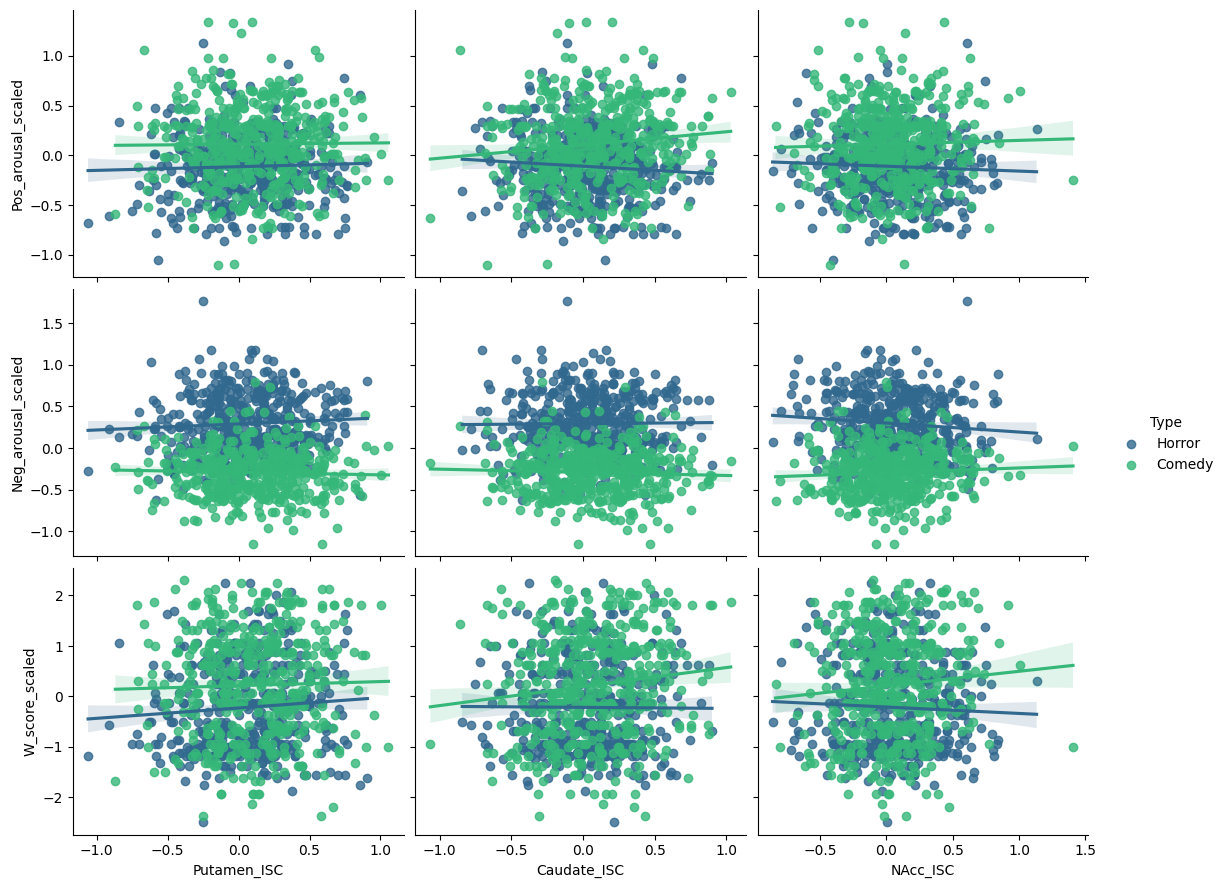

In [44]:
plot_test = sns.pairplot(
    all_subjects_isc_df,
    kind="reg",
    x_vars=['Putamen_ISC', "Caudate_ISC", "NAcc_ISC"],
    y_vars=["Pos_arousal_scaled", "Neg_arousal_scaled", "W_score_scaled"], 
        hue="Type",
        palette="viridis", 
        height=3,
        aspect=1.25)

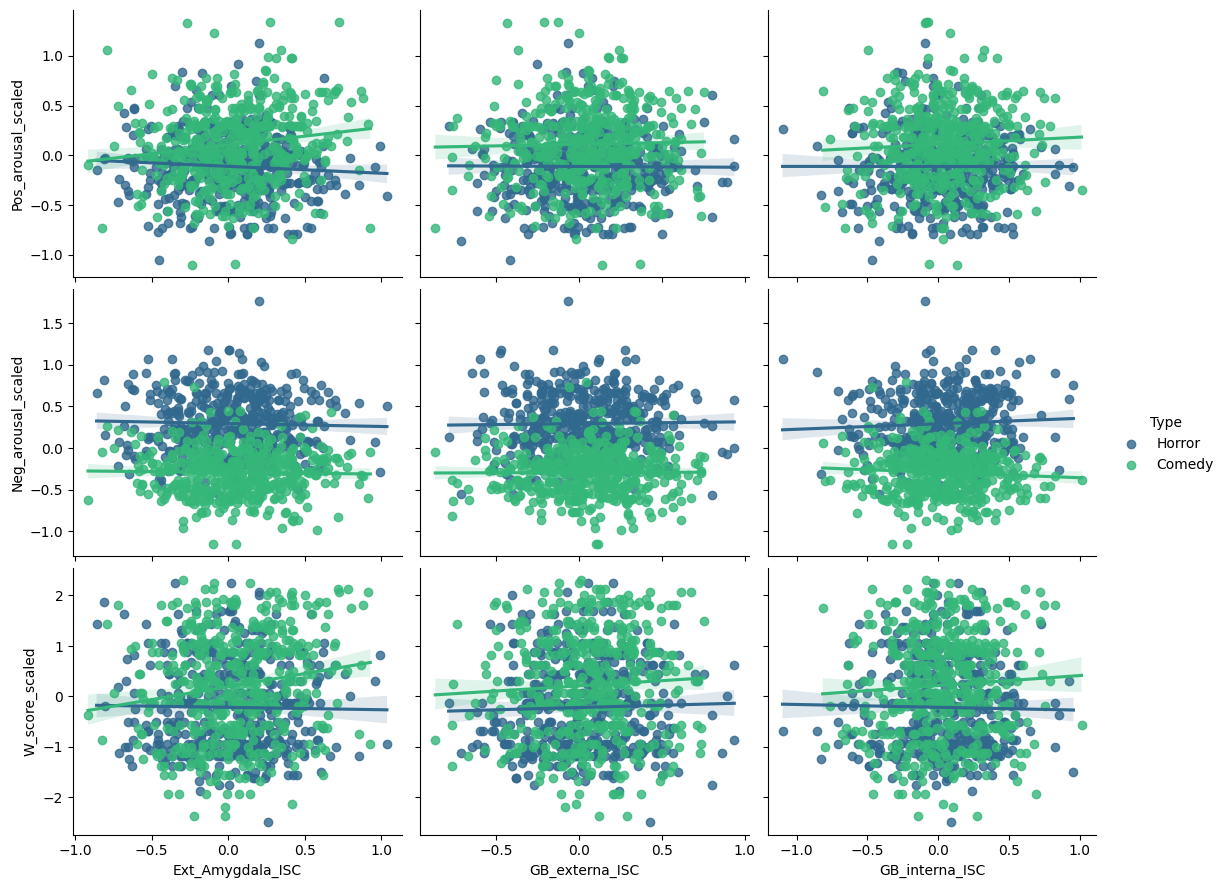

In [46]:
plot_test = sns.pairplot(
    all_subjects_isc_df,
    kind="reg",
    x_vars=['Ext_Amygdala_ISC', "GB_externa_ISC", "GB_interna_ISC"],
    y_vars=["Pos_arousal_scaled", "Neg_arousal_scaled", "W_score_scaled"], 
        hue="Type",
        palette="viridis", 
        height=3,
        aspect=1.25)


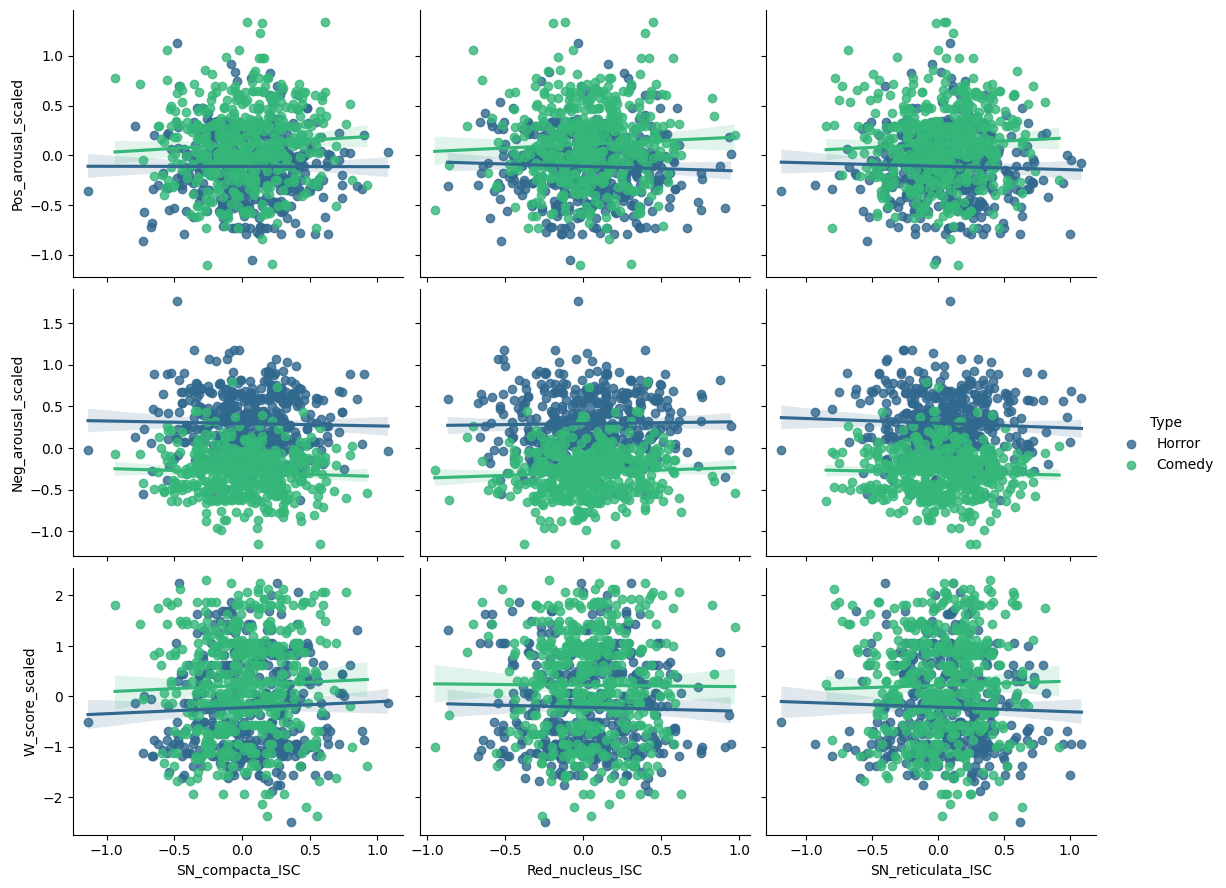

In [48]:
plot_test = sns.pairplot(
    all_subjects_isc_df,
    kind="reg",
    x_vars=['SN_compacta_ISC', "Red_nucleus_ISC", "SN_reticulata_ISC"],
    y_vars=["Pos_arousal_scaled", "Neg_arousal_scaled", "W_score_scaled"], 
        hue="Type",
        palette="viridis", 
        height=3,
        aspect=1.25)

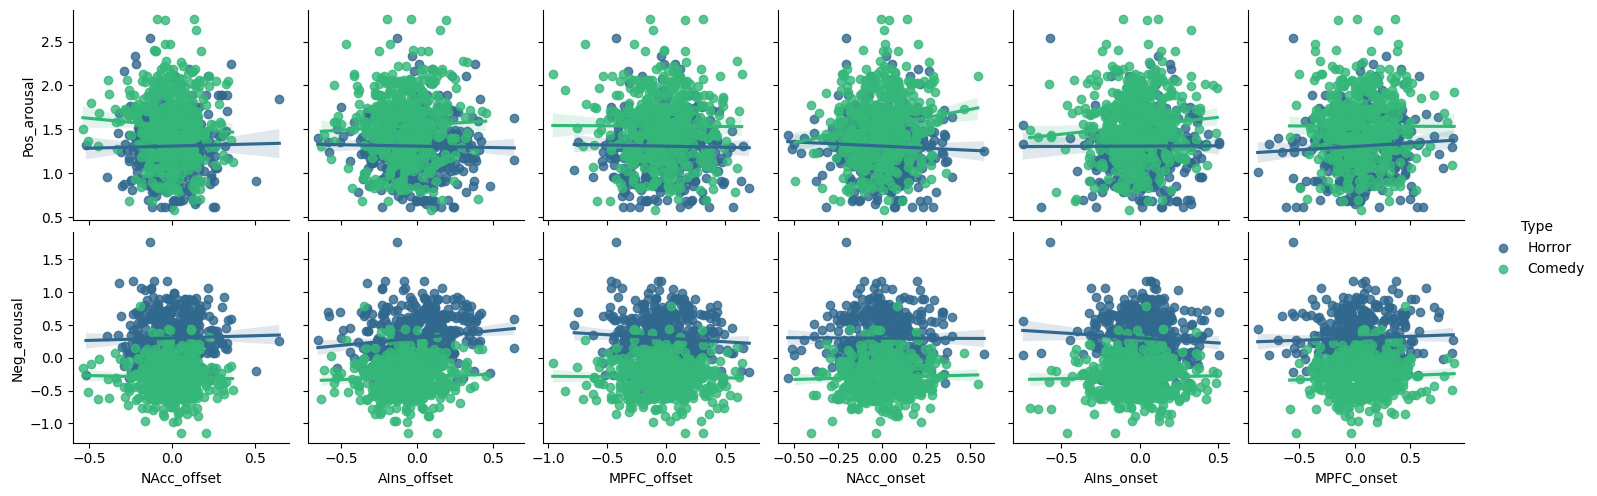

In [ ]:
# Drop outliers from positive arousal. 
all_subs_events_df = all_subs_events_df[all_subs_events_df["Pos_arousal"] < 3]
all_subs_events_df.head()
sns.pairplot(
    all_subs_events_df,
    kind="reg",
    x_vars=["NAcc_offset", "AIns_offset", "MPFC_offset", "NAcc_onset", "AIns_onset", "MPFC_onset"],
    y_vars=["Pos_arousal", "Neg_arousal"], 
    hue="Type",
    palette="viridis")

In [ ]:
all_subs_events_df.keys()

Index(['Participant', 'Trailer', 'Type', 'Onset', 'Offset', 'Duration',
       'W_score', 'A_score', 'F_score', 'NAcc_onset',
       ...
       'MPFC_TR6', 'MPFC_TR7', 'MPFC_TR8', 'MPFC_TR9', 'MPFC_TR10',
       'MPFC_TR11', 'MPFC_TR12', 'MPFC_TR13', 'MPFC_TR14', 'MPFC_TR15'],
      dtype='object', length=104)

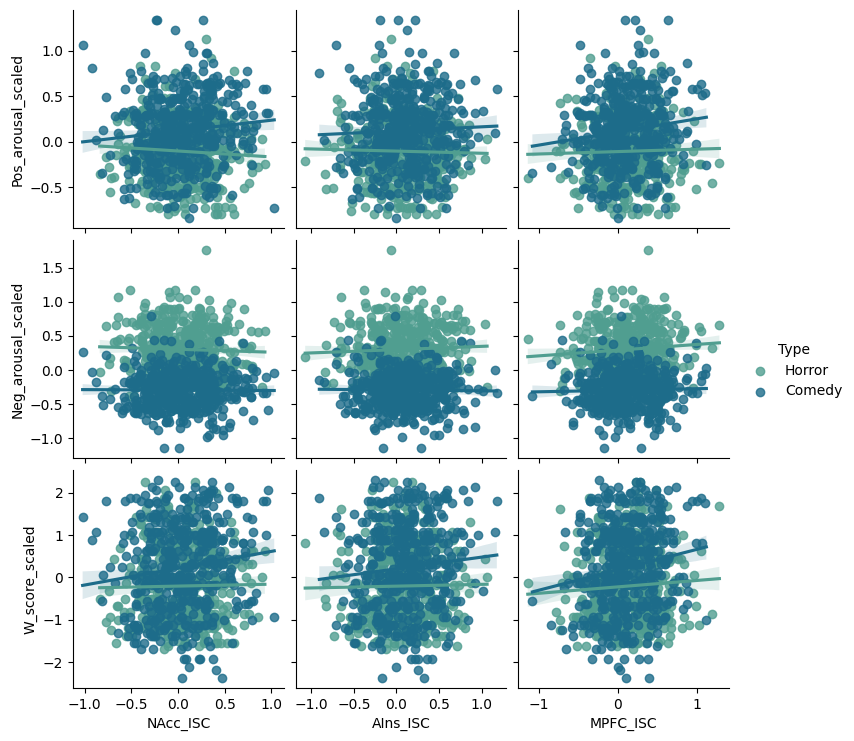

In [ ]:
sns.pairplot(
    all_subs_events_df,
    kind="reg",
    x_vars=["NAcc_ISC", "AIns_ISC", "MPFC_ISC",],
    y_vars=["Pos_arousal_scaled", "Neg_arousal_scaled", "W_score_scaled"], 
    hue="Type",
    palette="crest")

In [ ]:
"""
# Loop through each trailer.
    for id_trailer in current_sub_trailer_keys: 

        # Create empty array to store the timecourses for the current trailer.
        # Accross all participants except the current participant. 
        current_trailer_timecourses_bNAcc = np.zeros((len(participant_list_filtered2), 15))
        current_trailer_timecourses_bAIns = np.zeros((len(participant_list_filtered2), 15))
        current_trailer_timecourses_bMPFC = np.zeros((len(participant_list_filtered2), 15))

        # Loop through each participant except the current participant.
        for id_sub2 in range(len(participant_list_filtered2)):

            current_sub2 = participant_list_filtered2[id_sub2]

            print(current_sub2)
            # Store the timecourse for the current participant.
            current_trailer_timecourses_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][id_trailer]["Bilateral_NAcc"]
            current_trailer_timecourses_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][id_trailer]["Bilateral_AIns"]
            current_trailer_timecourses_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][id_trailer]["Bilateral_MPFC"]

        # Calculate the mean timecourse for the group without the current participant.
        mean_timecourse_bNAcc = np.mean(current_trailer_timecourses_bNAcc, axis=0)
        mean_timecourse_bAIns = np.mean(current_trailer_timecourses_bAIns, axis=0)
        mean_timecourse_bMPFC = np.mean(current_trailer_timecourses_bMPFC, axis=0)

        # Calculate the ISC for the current trailer for the current participant.
        # Store correlation value regardless of significance.
        # Note, there is a bit of an improvement when using the last 10 TRs, compared to the whole time course.
        current_sub_timecourses[id_trailer] = {"Bilateral_NAcc": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][id_trailer]["Bilateral_NAcc"], mean_timecourse_bNAcc)[0]),
                                               "Bilateral_AIns": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][id_trailer]["Bilateral_AIns"], mean_timecourse_bAIns)[0]),
                                               "Bilateral_MPFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][id_trailer]["Bilateral_MPFC"], mean_timecourse_bMPFC)[0])}
                                              
"""

'\n# Loop through each trailer.\n    for id_trailer in current_sub_trailer_keys: \n\n        # Create empty array to store the timecourses for the current trailer.\n        # Accross all participants except the current participant. \n        current_trailer_timecourses_bNAcc = np.zeros((len(participant_list_filtered2), 15))\n        current_trailer_timecourses_bAIns = np.zeros((len(participant_list_filtered2), 15))\n        current_trailer_timecourses_bMPFC = np.zeros((len(participant_list_filtered2), 15))\n\n        # Loop through each participant except the current participant.\n        for id_sub2 in range(len(participant_list_filtered2)):\n\n            current_sub2 = participant_list_filtered2[id_sub2]\n\n            print(current_sub2)\n            # Store the timecourse for the current participant.\n            current_trailer_timecourses_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][id_trailer]["Bilateral_NAcc"]\n            current_trailer_timecourses_bAIns[id_